# Lab 3

In [1]:
### MATPLOTLIB SETUP ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
pd.set_option('display.float_format', lambda x: '%e' % x)

## Amit's library with some utility functions for reading and processing scope data; reproduced below
sys.path.append("../../")
from lib import *

from rich.console import Console
from rich.syntax import Syntax
Console().print(Syntax.from_path("../../lib.py", line_numbers=True, theme="monokai"))

## Jupyter magic
%matplotlib
%matplotlib ipympl
%load_ext autoreload
%autoreload 2


   1 import csv                                                                                                    
   2 import pandas as pd                                                                                           
   3 import numpy as np                                                                                            
   4                                                                                                               
   5 # read funky Rigol CSV format                                                                                 
   6 def read_rigol_csv(csv_file_name):                                                                            
   7     with open(csv_file_name) as f:                                                                            
   8         rows = list(csv.reader(f))                                                                            
   9         i = 0                                                                                                 
  10         while rows[0][i] != "":                                                                               
  11             i = i+1                                                                                           
  12         numcols = i-2                                                                                         
  13         t0 = float(rows[1][numcols])                                                                          
  14         dT = float(rows[1][numcols+1])                                                                        
  15                                                                                                               
  16     data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])                                 
  17     data['X'] = t0+data['X']*dT                                                                               
  18     return data, t0, dT                                                                                       
  19                                                                                                               
  20 def import_and_clean(name, cols, filt):                                                                       
  21     """                                                                                                       
  22     Import and clean some data from the Rigol scope                                                           
  23                                                                                                               
  24     @param name: name of csv file (assumed to live in `./data`)                                               
  25     @param cols: what to rename columns to                                                                    
  26     @param filt: whether to apply 10 sample rolling mean LPF                                                  
  27                                                                                                               
  28     @return pd.df - renamed/filtered dataframe                                                                
  29     """                                                                                                       
  30     data, t0, dT = read_rigol_csv(f"data/{name}.csv")                                                         
  31     data[cols[0]] = data['CH1'].rolling(10).mean() if filt else data['

Using matplotlib backend: module://matplotlib_inline.backend_inline


### Prework

**Assembly Steps**

1. We began with a blank board, and applied solder paste to it using the stencil

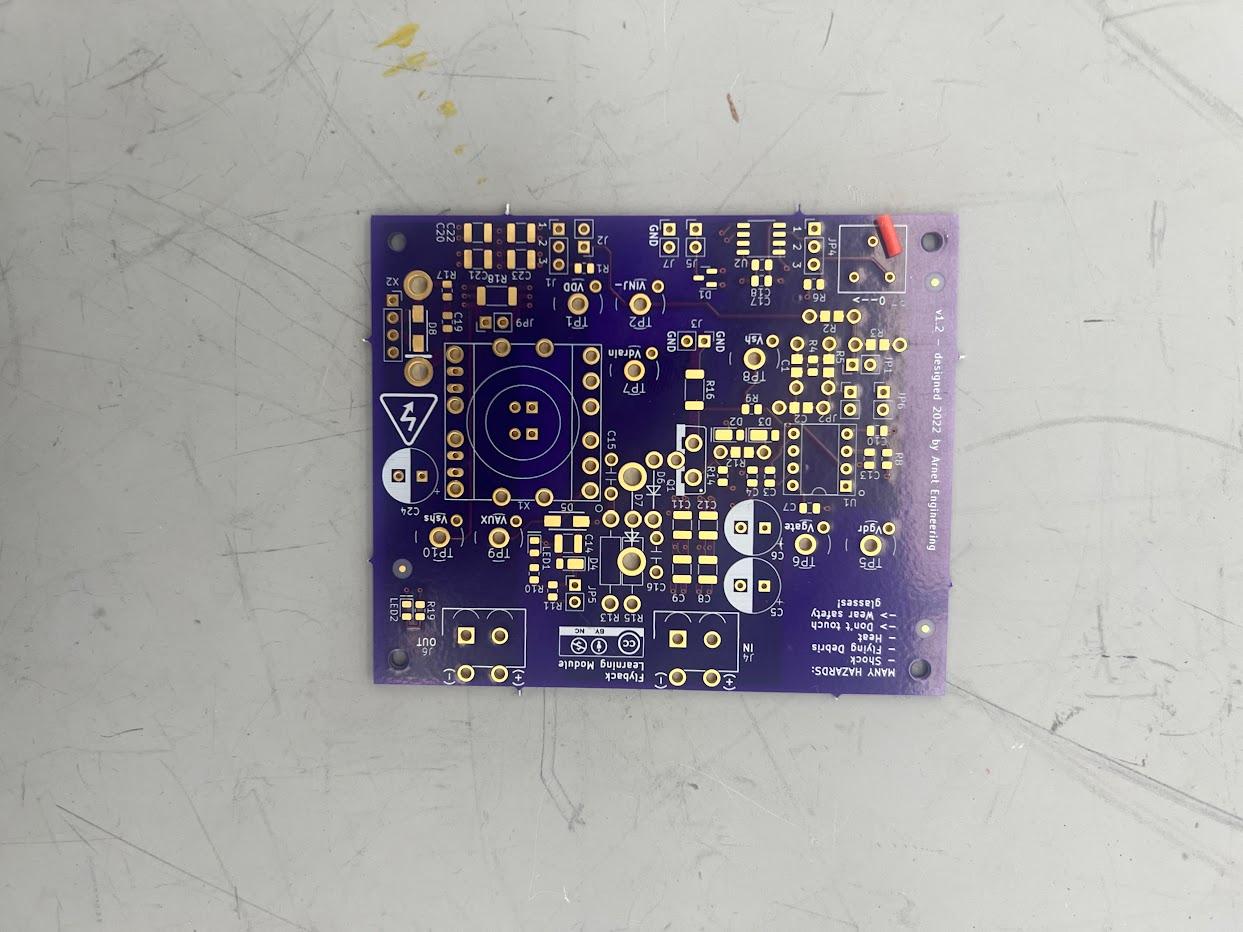

2. Using tweezers and a microscope, we then placed the SMT components on the board.

3. We then reflowed with the oven in the EE proto room using the LF-Large profile per the most recent documentation from the Formula team, which uses the oven to bake boards fairly regularly. Some of the solder didn't fully flow, so we touched up some areas with hot air/soldering iron. (I was the one primarily completing this task)

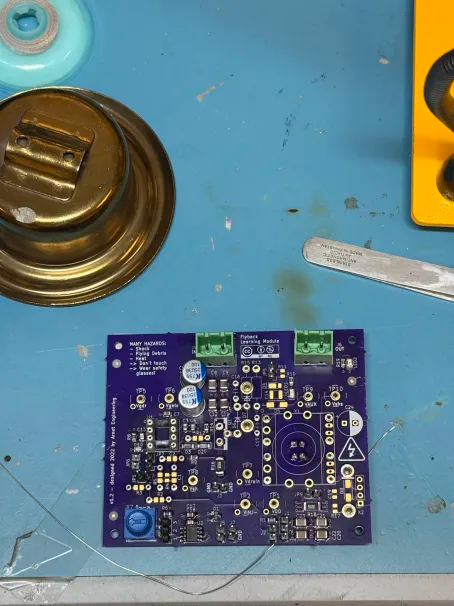

4. Next, we soldered all the through hole components, including capacitors and pin headers. We used the solder sucker as well to redo some connections that weren't quite aligned (pictured)

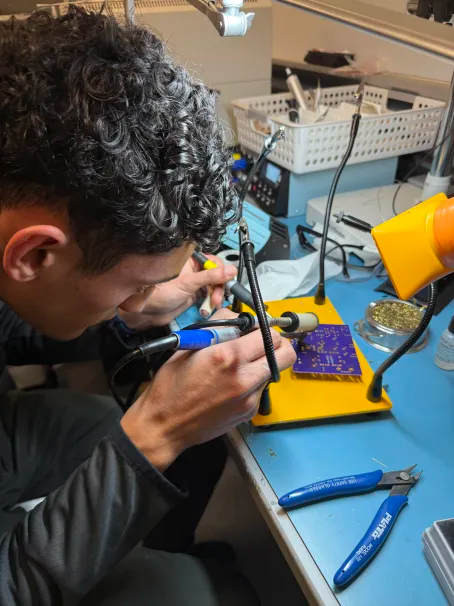

5. We then soldered in the pin sockets and added the standoffs, creating the final version of our board

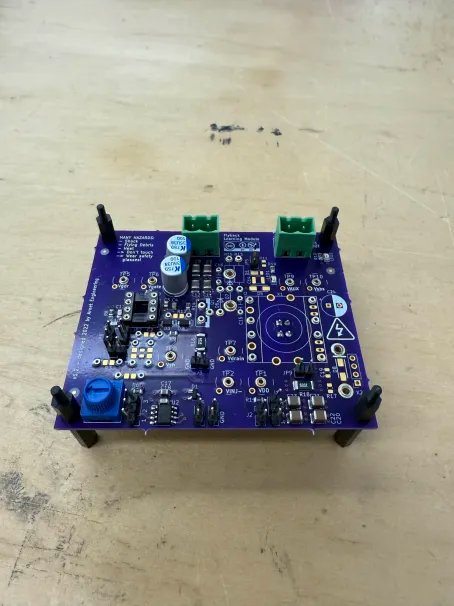

### Load Resistor Assembly

1. After gathering our materials, we began by marking and drilling two holes with the 43 bit into the heat sink to mount the resistor with the Minishop drill press, tapping the whole with a tap from the main shop, and mounting the resistor in place with two 4-40 screws (and some thermal grease in between) (I primarily completed this step)

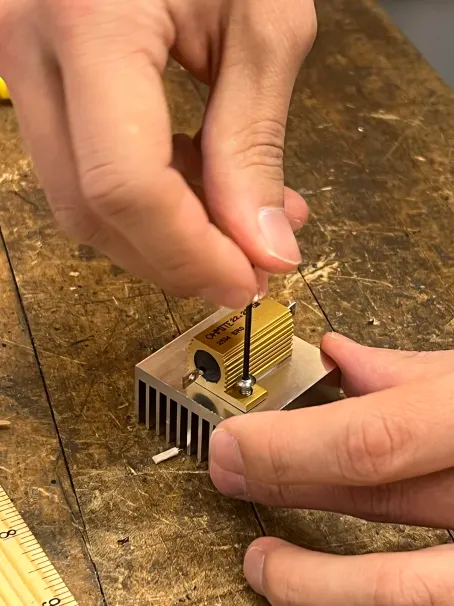

2. We next taped the fan onto the bottom of the heat sink resistor assembly using copper tape

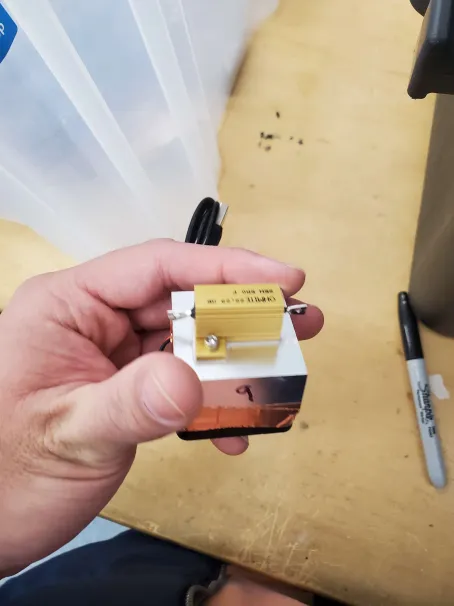

3. Lastly, we soldered the wire leads onto the resistor terminals, connected the other ends to the screw pin terminal, and covered the solder joints in electrical tape.

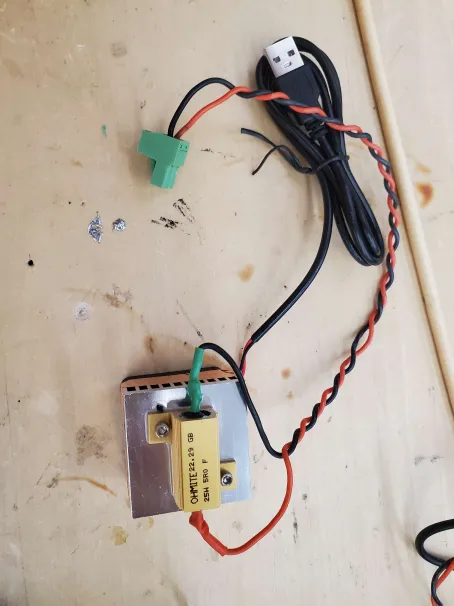

## Lab Questions

### Q1

Using our oscilloscope measurement and the cursor function, we measured our gate voltage amplitude to be 16.5V, our duty cycle as 52.28%, and our frequency as 50.50 kHz. 

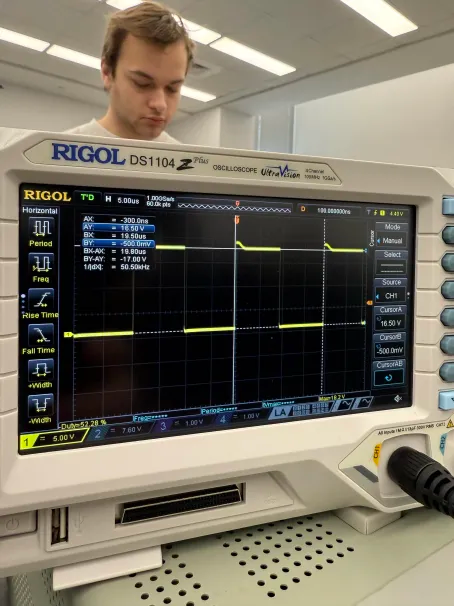

### Q2

We used test inductor #7.

### Q3

First we need to find the peak current, which we can do by dividing shunt voltage by shunt resistance by Ohm's law. The below code cell plots calculated current and find the peak for each of our three experiments (4V, 7V, and 9V) 

In [2]:
### CONSTANTS ###
R = 5 # Load Resistance
V = [4.068, 6.98, 9.0]  # Measured output voltages
Vg = 18 # Input Voltage
Fs = 50500 # Measured frequency
Ts = 1/ Fs
R_SHUNT = 0.05 # from schematic


Peak Current:  2.44
Peak Current:  3.656
Peak Current:  4.223999999999999


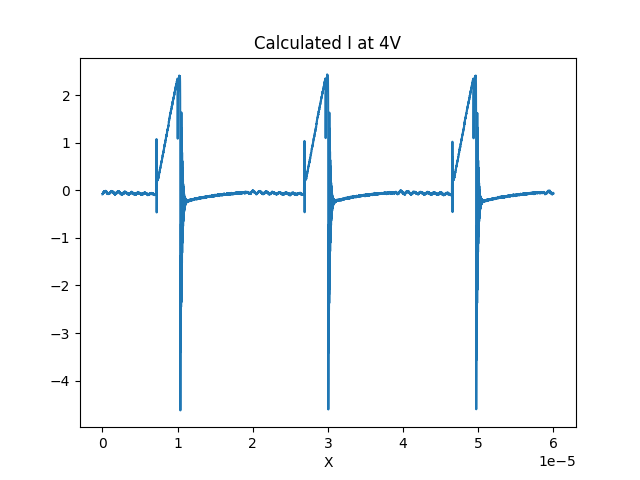

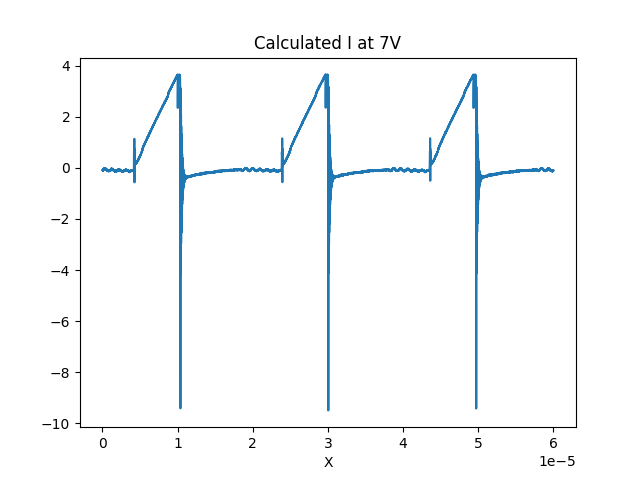

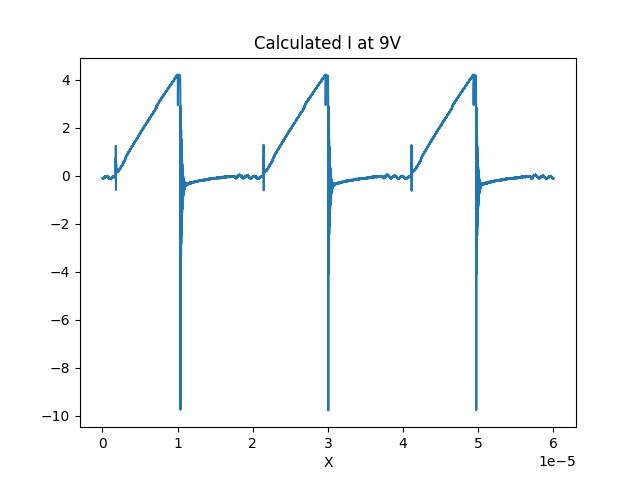

In [3]:
Ipks = []
for v in ['4v', '7v', '9v']:
    data, t0, dT = read_rigol_csv(f"data/t1_{v}.csv")
    data['Vshunt_filt'] = data['CH2'].rolling(10).mean() # LPF to smooth out voltage spike at peak current when the FET switches
    data['I_calc'] = data['Vshunt_filt'] / 0.05
    data['X'] = data['X'].add(-data['X'][0])
    data.plot(x="X", y="I_calc", legend=False, title=f"Calculated I at {v.upper()}")
    print("Peak Current: ", pk := max(data['I_calc'].dropna()))
    Ipks.append(pk)
    

Using my work from the end of Lab 3, I calculated the inductance from peak current using the equations

$$
\alpha =(\frac{2V}{R∗Ipk})^2
$$
$$
L = \alpha * ((1−M)∗R∗\frac{T_s}{2})
$$

This is represented in the code cell below (performed once for each experiment, and averaged at the end)

In [4]:
Ls = np.empty((3,1))
for i, pk in enumerate(Ipks):
    M = V[i] / Vg
    alpha = ((2*V[i])/(R*pk))**2
    Lcrit = (1-M) * R * (Ts/2) 
    L = alpha * Lcrit
    Ls[i] = L
    print("Calculated inductance value: ", L)

print("Mean inductance: ", np.mean(Ls))

Calculated inductance value:  1.7040871819296954e-05
Calculated inductance value:  1.7675681759768945e-05
Calculated inductance value:  1.7979425783487446e-05
Mean inductance:  1.7565326454184447e-05


### Q4
Updated inductance and frequency in my digital twin as shown

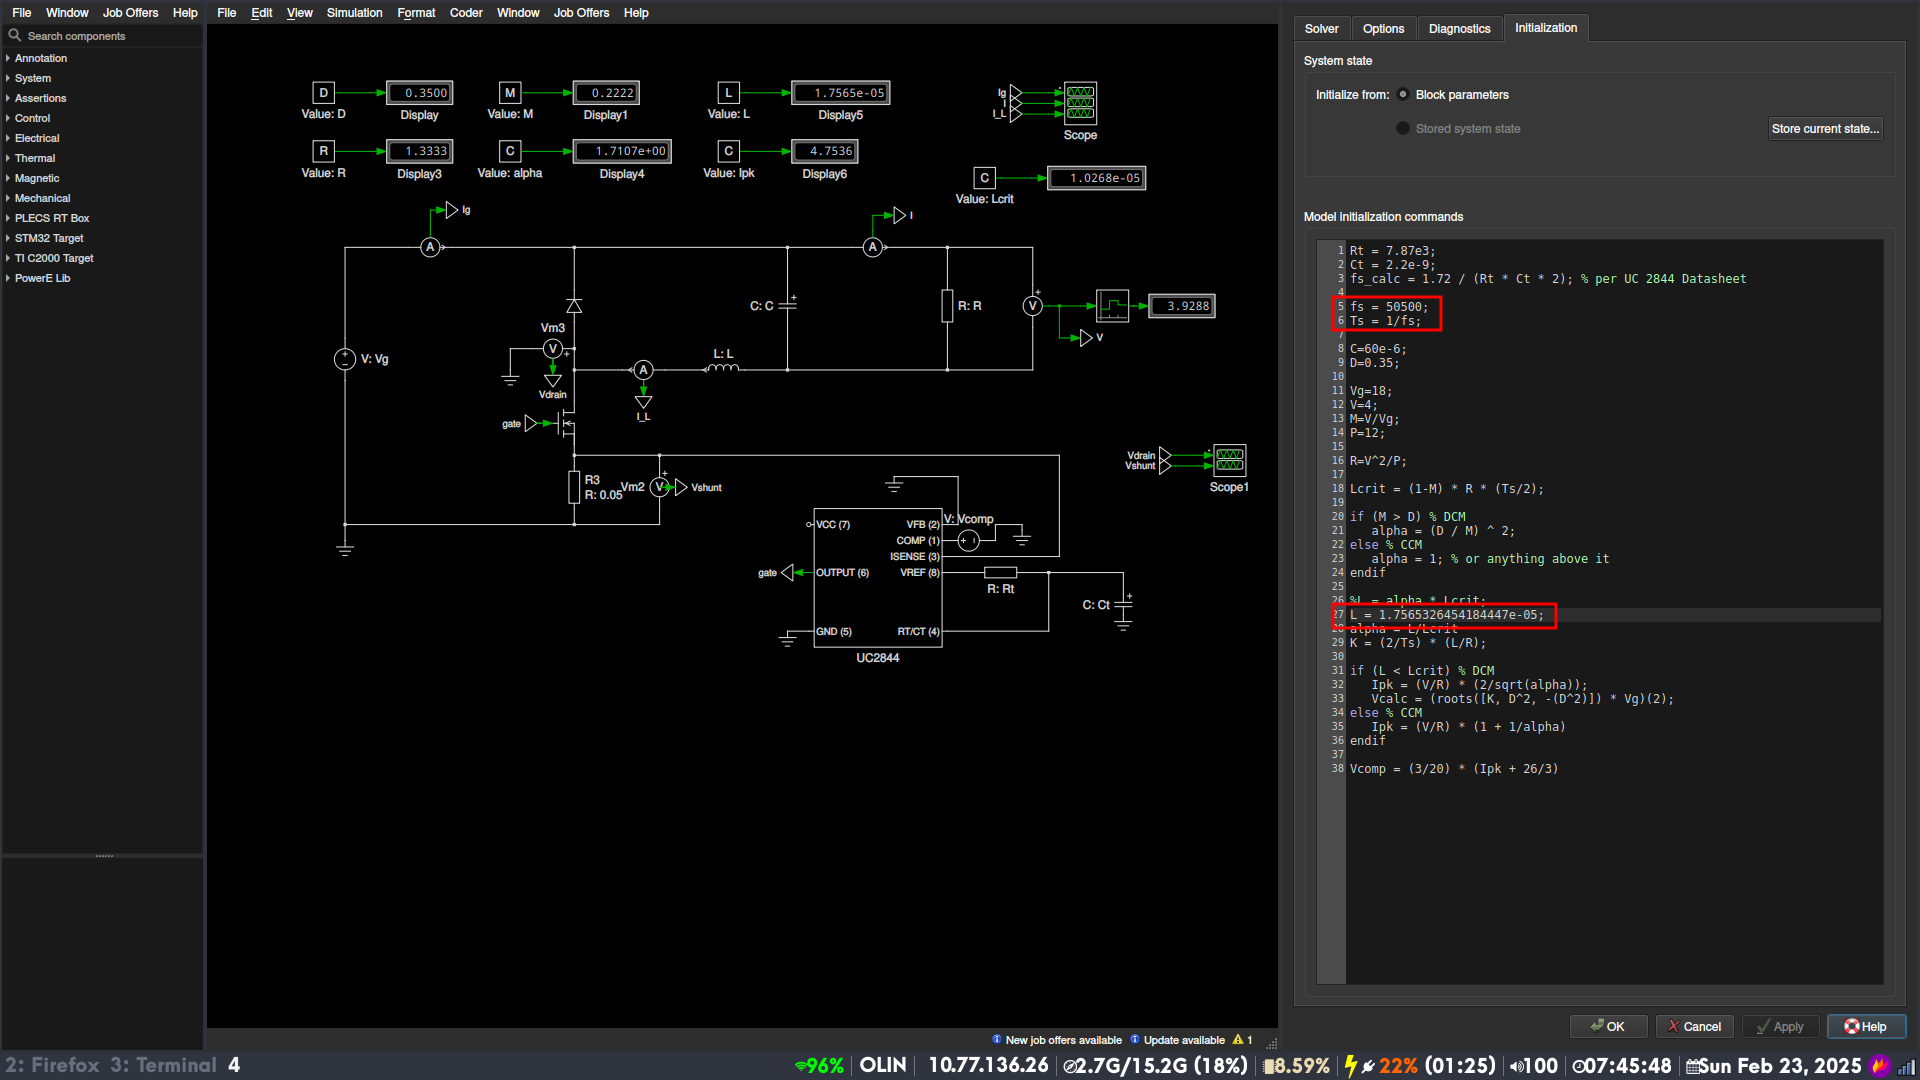


### Q5

For this, I have plotted the sim results for the converter at 4V, 7V and 9V outputs, as well as our measured hardware results in the code cell below

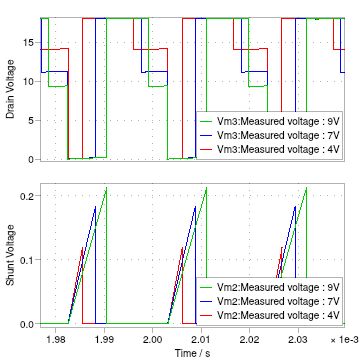

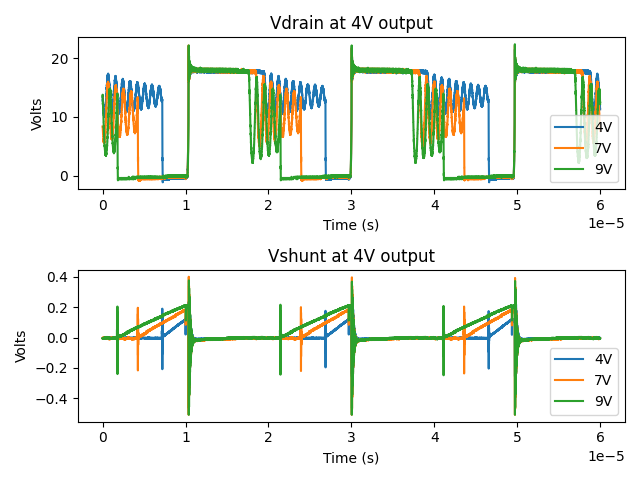

In [5]:
from lib import *

v4, _ = import_and_clean("t1_4v", ['Vdrain', 'Vshunt'], False)
v7, _ = import_and_clean("t1_7v", ['Vdrain', 'Vshunt'], False)
v9, _ = import_and_clean("t1_9v", ['Vdrain', 'Vshunt'], False)
fig, (a1, a2) = plt.subplots(2,1)
v4.plot(x="X", y="Vdrain", legend=False, title=f"Vdrain at 4V output", xlabel="Time (s)", ylabel="Volts", ax=a1)
v4.plot(x="X", y="Vshunt", legend=False, title=f"Vshunt at 4V output", xlabel="Time (s)", ylabel="Volts", ax=a2)
v7.plot(x="X", y="Vdrain", legend=False, title=f"Vdrain at 4V output", xlabel="Time (s)", ylabel="Volts", ax=a1)
v7.plot(x="X", y="Vshunt", legend=False, title=f"Vshunt at 4V output", xlabel="Time (s)", ylabel="Volts", ax=a2)
v9.plot(x="X", y="Vdrain", legend=False, title=f"Vdrain at 4V output", xlabel="Time (s)", ylabel="Volts", ax=a1)
v9.plot(x="X", y="Vshunt", legend=False, title=f"Vshunt at 4V output", xlabel="Time (s)", ylabel="Volts", ax=a2)
fig.tight_layout()
a1.legend(['4V', '7V', '9V'], loc="lower right")
a2.legend(['4V', '7V', '9V'])

The plots follow the same general shape, but the real output contains some additional artifacts. There is a voltage spike in the shunt voltage when the FET opens and closes (perhaps due to EMI from rapidly changing current?). The Vdrain also has a minor spike when the FET turns off, and a large sinusoidal ripple (perhaps from various parasitic capacitances/inductances) when the inductor is fully discharged.

Amplitude wise, the drain voltage appears to be a good match (at our supply voltage, 18V) when the FET turns off, 0V when the FET turns on, and although the real graph enters the sinusoidal oscillation when the diode and FET are both off, it appears to be centered around a similar votlage to the corresponding simulated Vdrain. The shunt voltages have similar peaks between the real and simulated waveforms, which makes sense as a lower output voltage would correspond to a lower peak current across both converters.

All of these graphs appear to have the same frequency, although there is a slight phase shift in the 9V version, perhaps due to longer ramp up time or other inconsistency in the initial condition? The same frequency would make sense because our switching frequency from the UC2844 chip remains constant no matter what voltage the converter is operating at right around ~50.5kHz in our case

The following code cell prints the duty cycle for each of our real waveforms (calculated from time when the FET drain voltages are low) for 4V, 7V, and 9V respectively

In [6]:
print(*[float(duty_cycle(x, 'Vdrain', 2.1e-5, 3.1e-5, Ts)) for x in [v4, v7, v9]])

0.15119700000007538 0.30087900000015 0.4257150000002123


And this table aggregates that data in comparison with what was measured with the PLECS scope (example trace from the 9V sim attached)

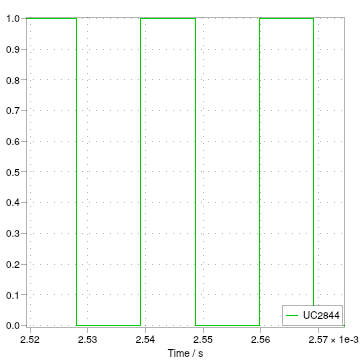


| Output Voltage | Real   | Sim    |
|----------------|--------|--------|
| 4V             | 15.12% | 16.05% |
| 7V             | 30.09% | 31.19% |
| 9V             | 42.57% | 46.21% |

The duty cycles are relatively comparable, with the smallest error at 4V, and the largest at 9V, but not more than about 3.7% or so. I'd imagine this is likely some form of measurement or rounding error from our experimentation chain, whether that's exact cursor positioning, frequency measurement, etc. 

### Q6

I think this is a nuanced quesiton that depends on what the model is being used for. At the end of the day no model is being perfect, and there is a trade-off between model accuracy and complexity. Simplifying components like using ideal capacitors and inductors, no parasitic inductance/capacitance, etc. for educational purposes like this class I'd say is very valid - simpler models are easier to understand, and they still operate under the same rules and broad trends even if the exact values are slightly off. However, my answer would probably change if I was designing a power converter with much stricter requirements or more serious safety concerns at play.

### Q7

The table below shows our real-life measured duty cycle and peak current, as well as their theoretical predictions. The real duty cycle and peak current were found in Q5 and Q3, respectively. The theoretical duty cycle was calculated like so

$$D = \sqrt{\alpha} * M$$

where $M = \frac{V}{V_g}$, and theoretical Ipk was calculated like so

$$I_{pk} = \frac{V}{R} * \frac{2}{\sqrt{\alpha}}$$

| Output Voltage | Real D | Predicted D | Real Ipk (A) | Predicted Ipk (A) |
|----------------|--------|-------------|--------------|-------------------|
| 4V             | 15.12% | 15.01%      | 2.44         | 2.369             |
| 7V             | 30.09% | 29.63%      | 3.656        | 3.675             |
| 9V             | 42.57% | 42.12%      | 4.224        | 4.274             |

Generally, these match up quite well - in fact, better than the empirically measured sim results from Q5, with only a few tenths of a percent of error in the duty cycle and a few dozen milliamps in Ipk. This was initially somewhat surprising, as I would have expected the theoretical predictions to be closer to the perfect simulation, but after thinking for a bit, I believe the most likely reason is because I performed my theoretical calculations with some parameters (like switching frequency) based on what we measured on our actual board, which may not exactly match the simmed UC2844. Additionally, the equation I am using for Vcomp may not be perfectly matched to what actually got us our output voltage on the real board 

### Q8

The below cell plots the gate voltage and current for our converter. The voltage shows switching frequency and duty cycle for turning our converter on and off, with higher voltage having a higher duty cycle, and the current shows spikes when the FET gate turns on and off.

Max gate voltage at 4V: 17.62
Max gate voltage at 7V: 17.580000000000002
Max gate voltage at 9V: 17.5


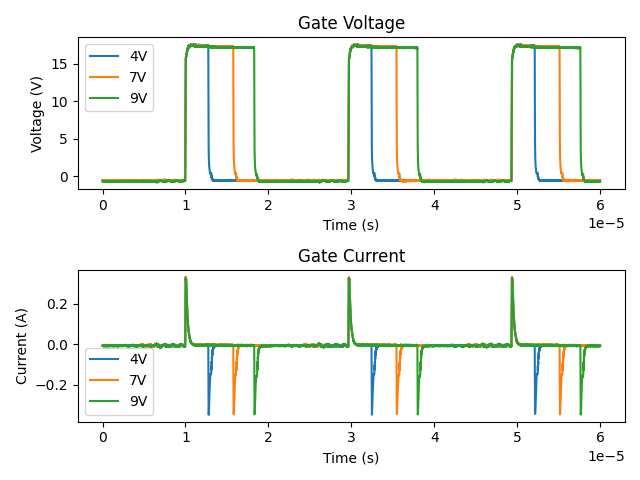

In [7]:
figure, [ax1, ax2] = plt.subplots(2, 1)
for v in ['4', '7', '9']:
    V, _ = import_and_clean(f"t2_{v}v", ["Vgdr", "Vgate"], True)
    I = (V["Vgate"] - V["Vgdr"])/33
    ax1.plot(V['X'], V["Vgate"])
    ax2.plot(V['X'], I)
    print(f"Max gate voltage at {v}V: {max(V['Vgate'].dropna())}")

ax1.legend(['4V', '7V', '9V'])
ax2.legend(['4V', '7V', '9V'], loc="lower left")
ax1.set_title("Gate Voltage")
ax2.set_title("Gate Current")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V)")
ax2.set_ylabel("Current (A)")
figure.tight_layout()

### Q9

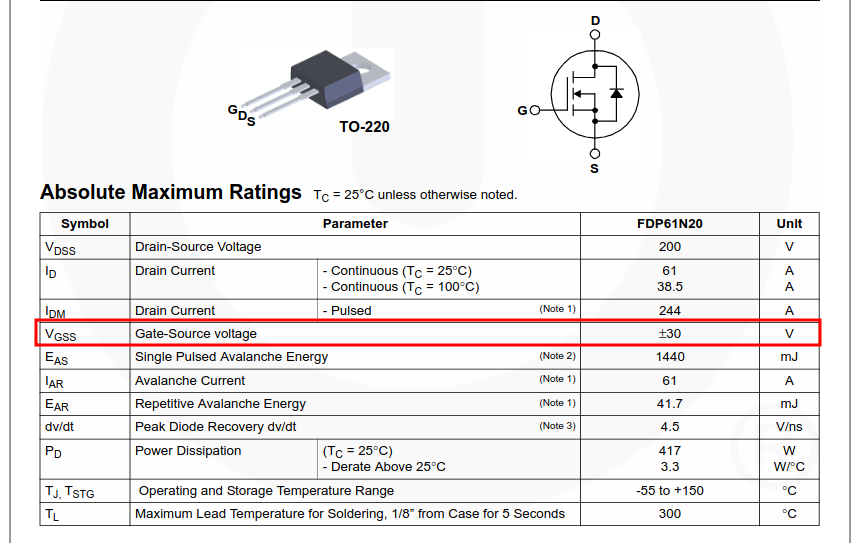

Per this snippet from the datasheet, the max voltage of our gate to source is 30V. As printed in the python code above, we are just under our supply voltage at 17V, so as long as our supply remains below 30V (minus a factor of safety), the MOSFET should be safe

### Q10

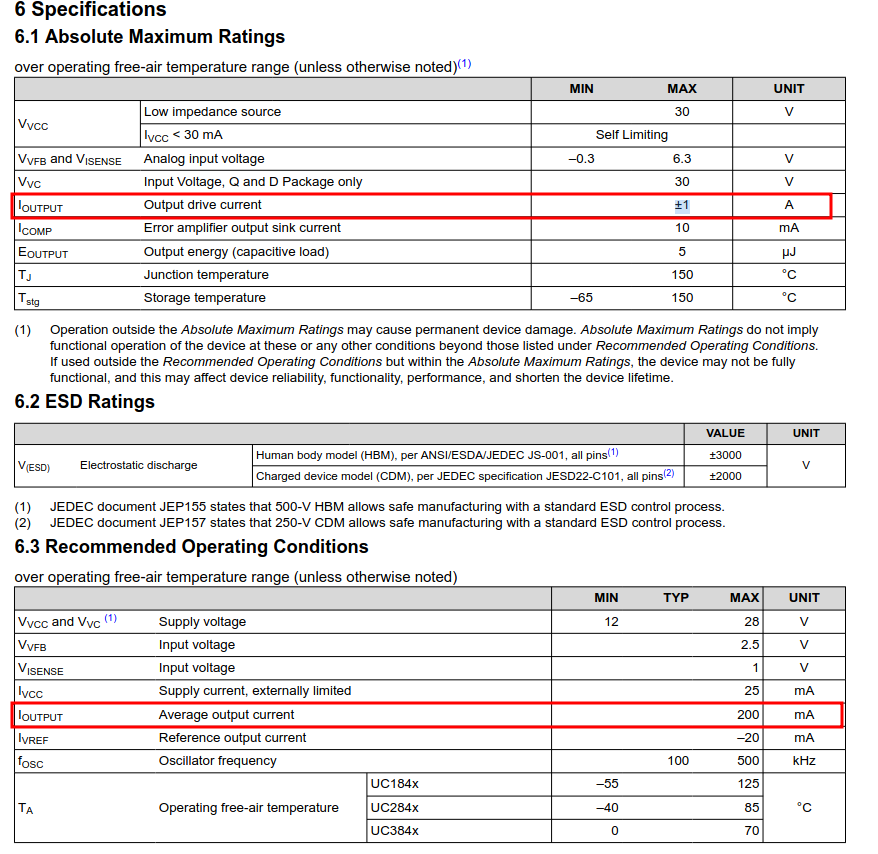

Per this snippet from the UC2844 datasheet, the absolute maximum rating is +- 1 amp, and the recommended operating condition is +- 200mA. Looking at the graph, it seems that our gate current is mostly stable around 0, but when the transistor switches, there is a spike of +-320 mA, which is higher than the recommended operating condition. We are within the absolute maximum at all times, so we are respecting that parameter. However, because we are operating in "no man's land" between the recommended and maximum values, the lifetime and performance of the part may be affected.  